In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler


### <font color='violet'> df from v5 used here, experimenting with ML models only from here on



In [2]:
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') # df here read from the csv in previous line

In [3]:
df_log_mass_filtered=df_log_mass_filtered_v5.drop(columns =['GalpropRedshift', 
                                               'GalpropRfric', 'HalopropMaccdot_metal', 'HalopropMaccdot_pristine',
                                               'HalopropMaccdot_reaccreate_metal', 'HalopropMcooldot',
                                               'HalopropMdot_eject', 'HalopropMdot_eject_metal',
                                               'GalpropX', 'GalpropVx','GalpropY', 'GalpropVy',
                                               'GalpropZ', 'GalpropVz', 'GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'GalpropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropRbulge',  'GalpropRdisk', 'GalpropMvir', 'GalpropMstrip'])

### Normalize SigmaBulge and Vdisk by Vvir

In [4]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [5]:
np.array(df_log_mass_filtered.loc[:,'HalopropMvir'])

array([4.50251007e+09, 1.28531006e+11, 1.17193001e+11, ...,
       5.17566986e+10, 5.43106003e+10, 5.27752991e+10])

In [6]:
v= Mvir_to_Vvir (np.array(df_log_mass_filtered.loc[:,'HalopropMvir']),0) # has units

In [7]:
v

<Quantity [21.18004688, 64.73085173, 62.76861958, ..., 47.8003278 ,
           48.5739648 , 48.11187183] km / s>

In [8]:
v.value #just the number

array([21.18004688, 64.73085173, 62.76861958, ..., 47.8003278 ,
       48.5739648 , 48.11187183])

In [9]:
df_log_mass_filtered.shape

(35390, 35)

In [10]:
df_log_mass_filtered.loc[:, 'HalopropVvir']=v.value

In [11]:
df_log_mass_filtered.shape

(35390, 36)

#### Check if SigmaBulge or Vdisk are equal Vvir

In [12]:
df_log_mass_filtered['GalpropSigmaBulge']==df_log_mass_filtered['HalopropVvir']

0        False
1        False
2        False
3        False
4        False
         ...  
35385    False
35386    False
35387    False
35388    False
35389    False
Length: 35390, dtype: bool

In [13]:
df_log_mass_filtered['GalpropVdisk']==df_log_mass_filtered['HalopropVvir']

0        False
1        False
2        False
3        False
4        False
         ...  
35385    False
35386    False
35387    False
35388    False
35389    False
Length: 35390, dtype: bool

In [14]:
df_log_mass_filtered['GalpropVdisk'].equals(df_log_mass_filtered['HalopropVvir'])

False

In [15]:
df_log_mass_filtered['GalpropSigmaBulge'].equals(df_log_mass_filtered['HalopropVvir'])

False

### Normalize the dataset by dividing masses by Mhalo and size by Rhalo

In [16]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    halomass=df.loc[:,'HalopropMvir']
    halorad= df.loc[:,'GalpropRhalo']
    
    df.loc[:,'GalpropNormHalfRadius']=df.loc[:,'GalpropHalfRadius']/halorad
    df.loc[:,'GalpropNormRhalo']=df.loc[:,'GalpropRhalo']/halorad

    df.loc[:,'GalpropNormMstar']=df.loc[:,'GalpropMstar']/halomass
#     df.loc[:,'GalpropNormMvir']=df.loc[:,'GalpropMvir']/halomass
    df.loc[:,'HalopropNormMhot']=df.loc[:,'HalopropMhot']/halomass
    df.loc[:,'GalpropNormMbulge']=df.loc[:,'GalpropMbulge']/halomass
    
    df.loc[:,'GalpropNormMBH']=df.loc[:,'GalpropMBH']/halomass
    df.loc[:,'GalpropNormMH2']=df.loc[:,'GalpropMH2']/halomass
    df.loc[:,'GalpropNormMHI']=df.loc[:,'GalpropMHI']/halomass
    df.loc[:,'GalpropNormMHII']=df.loc[:,'GalpropMHII']/halomass
    df.loc[:,'GalpropNormMcold']=df.loc[:,'GalpropMcold']/halomass
    df.loc[:,'GalpropNormMstar_merge']=df.loc[:,'GalpropMstar_merge']/halomass
#     df.loc[:,'GalpropNormMstrip']=df.loc[:,'GalpropMstrip']/halomass
    
    df.loc[:,'HalopropNormMass_ejected']=df.loc[:,'HalopropMass_ejected']/halomass
    df.loc[:,'HalopropNormMstar_diffuse']=df.loc[:,'HalopropMstar_diffuse']/halomass
    df.loc[:,'HalopropNormMvir']=df.loc[:,'HalopropMvir']/halomass
    
    df.loc[:,'GalpropNormSigmaBulge']=df.loc[:,'GalpropSigmaBulge']/df.loc[:,'HalopropVvir']
    df.loc[:,'GalpropNormVdisk']=df.loc[:,'GalpropVdisk']/df.loc[:,'HalopropVvir']
    
    return df

In [17]:
df_log_mass_filtered.shape

(35390, 36)

In [18]:
df_normalized=normalization_func(df_log_mass_filtered)

In [19]:
df_normalized.shape

(35390, 52)

In [20]:
df_normalized.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,HalopropNormMvir,GalpropNormSigmaBulge,GalpropNormVdisk
0,130136.002554,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,0.000000,6.019998e-21,0.000051,0.000068,0.000312,1.515728,0.000297,1.0,1.043841,0.993086
1,541275.017895,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,0.001132,3.353354e-03,0.001949,0.008648,0.000319,0.246429,0.000139,1.0,0.966487,1.300616


In [21]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMbulge',
       'GalpropMcold', 'GalpropMstar', 'GalpropMstar_merge',
       'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropRhalo', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropSigmaBulge', 'GalpropTmerger', 'GalpropTmerger_major',
       'GalpropVdisk', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMass_ejected', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropSpin', 'HalopropZhot',
       'GalpropHalfRadius', 'HalopropVvir', 'GalpropNormHalfRadius',
       'GalpropNormRhalo', 'GalpropNormMstar', 'HalopropNormMhot',
       'GalpropNormMbulge', 'GalpropNormMBH', 'GalpropNormMH2',
       'GalpropNormMHI'

In [22]:
round(stats.spearmanr(df_log_mass_filtered_v5['GalpropVdisk'], df_log_mass_filtered_v5['GalpropRdisk'])[0], 2)



0.4

In [23]:
round(stats.spearmanr(df_log_mass_filtered_v5['GalpropVdisk'], df_log_mass_filtered_v5['HalopropMvir'])[0], 2)



0.92

In [24]:
# drop the original columns of normalized features + columns used for normalization
df_normalized=df_normalized.drop(columns=['GalpropHalfRadius',  'GalpropMstar',
 'HalopropMhot','GalpropMbulge','GalpropMBH','GalpropMH2','GalpropMHI','GalpropMHII',
 'GalpropMcold','GalpropMstar_merge','HalopropMass_ejected',
 'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 'GalpropRhalo','GalpropNormRhalo', 'HalopropVvir',
                                        'GalpropSigmaBulge', 'GalpropVdisk' ])

In [25]:
df_normalized.shape

(35390, 33)

In [26]:
df_normalized['GalpropNormHalfRadius'].max()

299.5099604575027

In [27]:
df_normalized['GalpropNormHalfRadius'].min()

0.002388319771819355

In [28]:
df_normalized['GalpropNormMstar'].max()

9.375894034110456

In [29]:
df_normalized['GalpropNormMstar'].min()

0.0005125728041806904

In [30]:
df_normalized['GalpropNormMbulge'].max()

9.356539536790457

In [31]:
df_normalized['GalpropNormMbulge'].min()

0.0

## Correlations matrix of Normalized dataset

In [32]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropNormHalfRadius', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk'],
      dtype='object')>

In [33]:
df_pairplot=df_normalized.loc[:,['GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk', 'GalpropNormHalfRadius']]

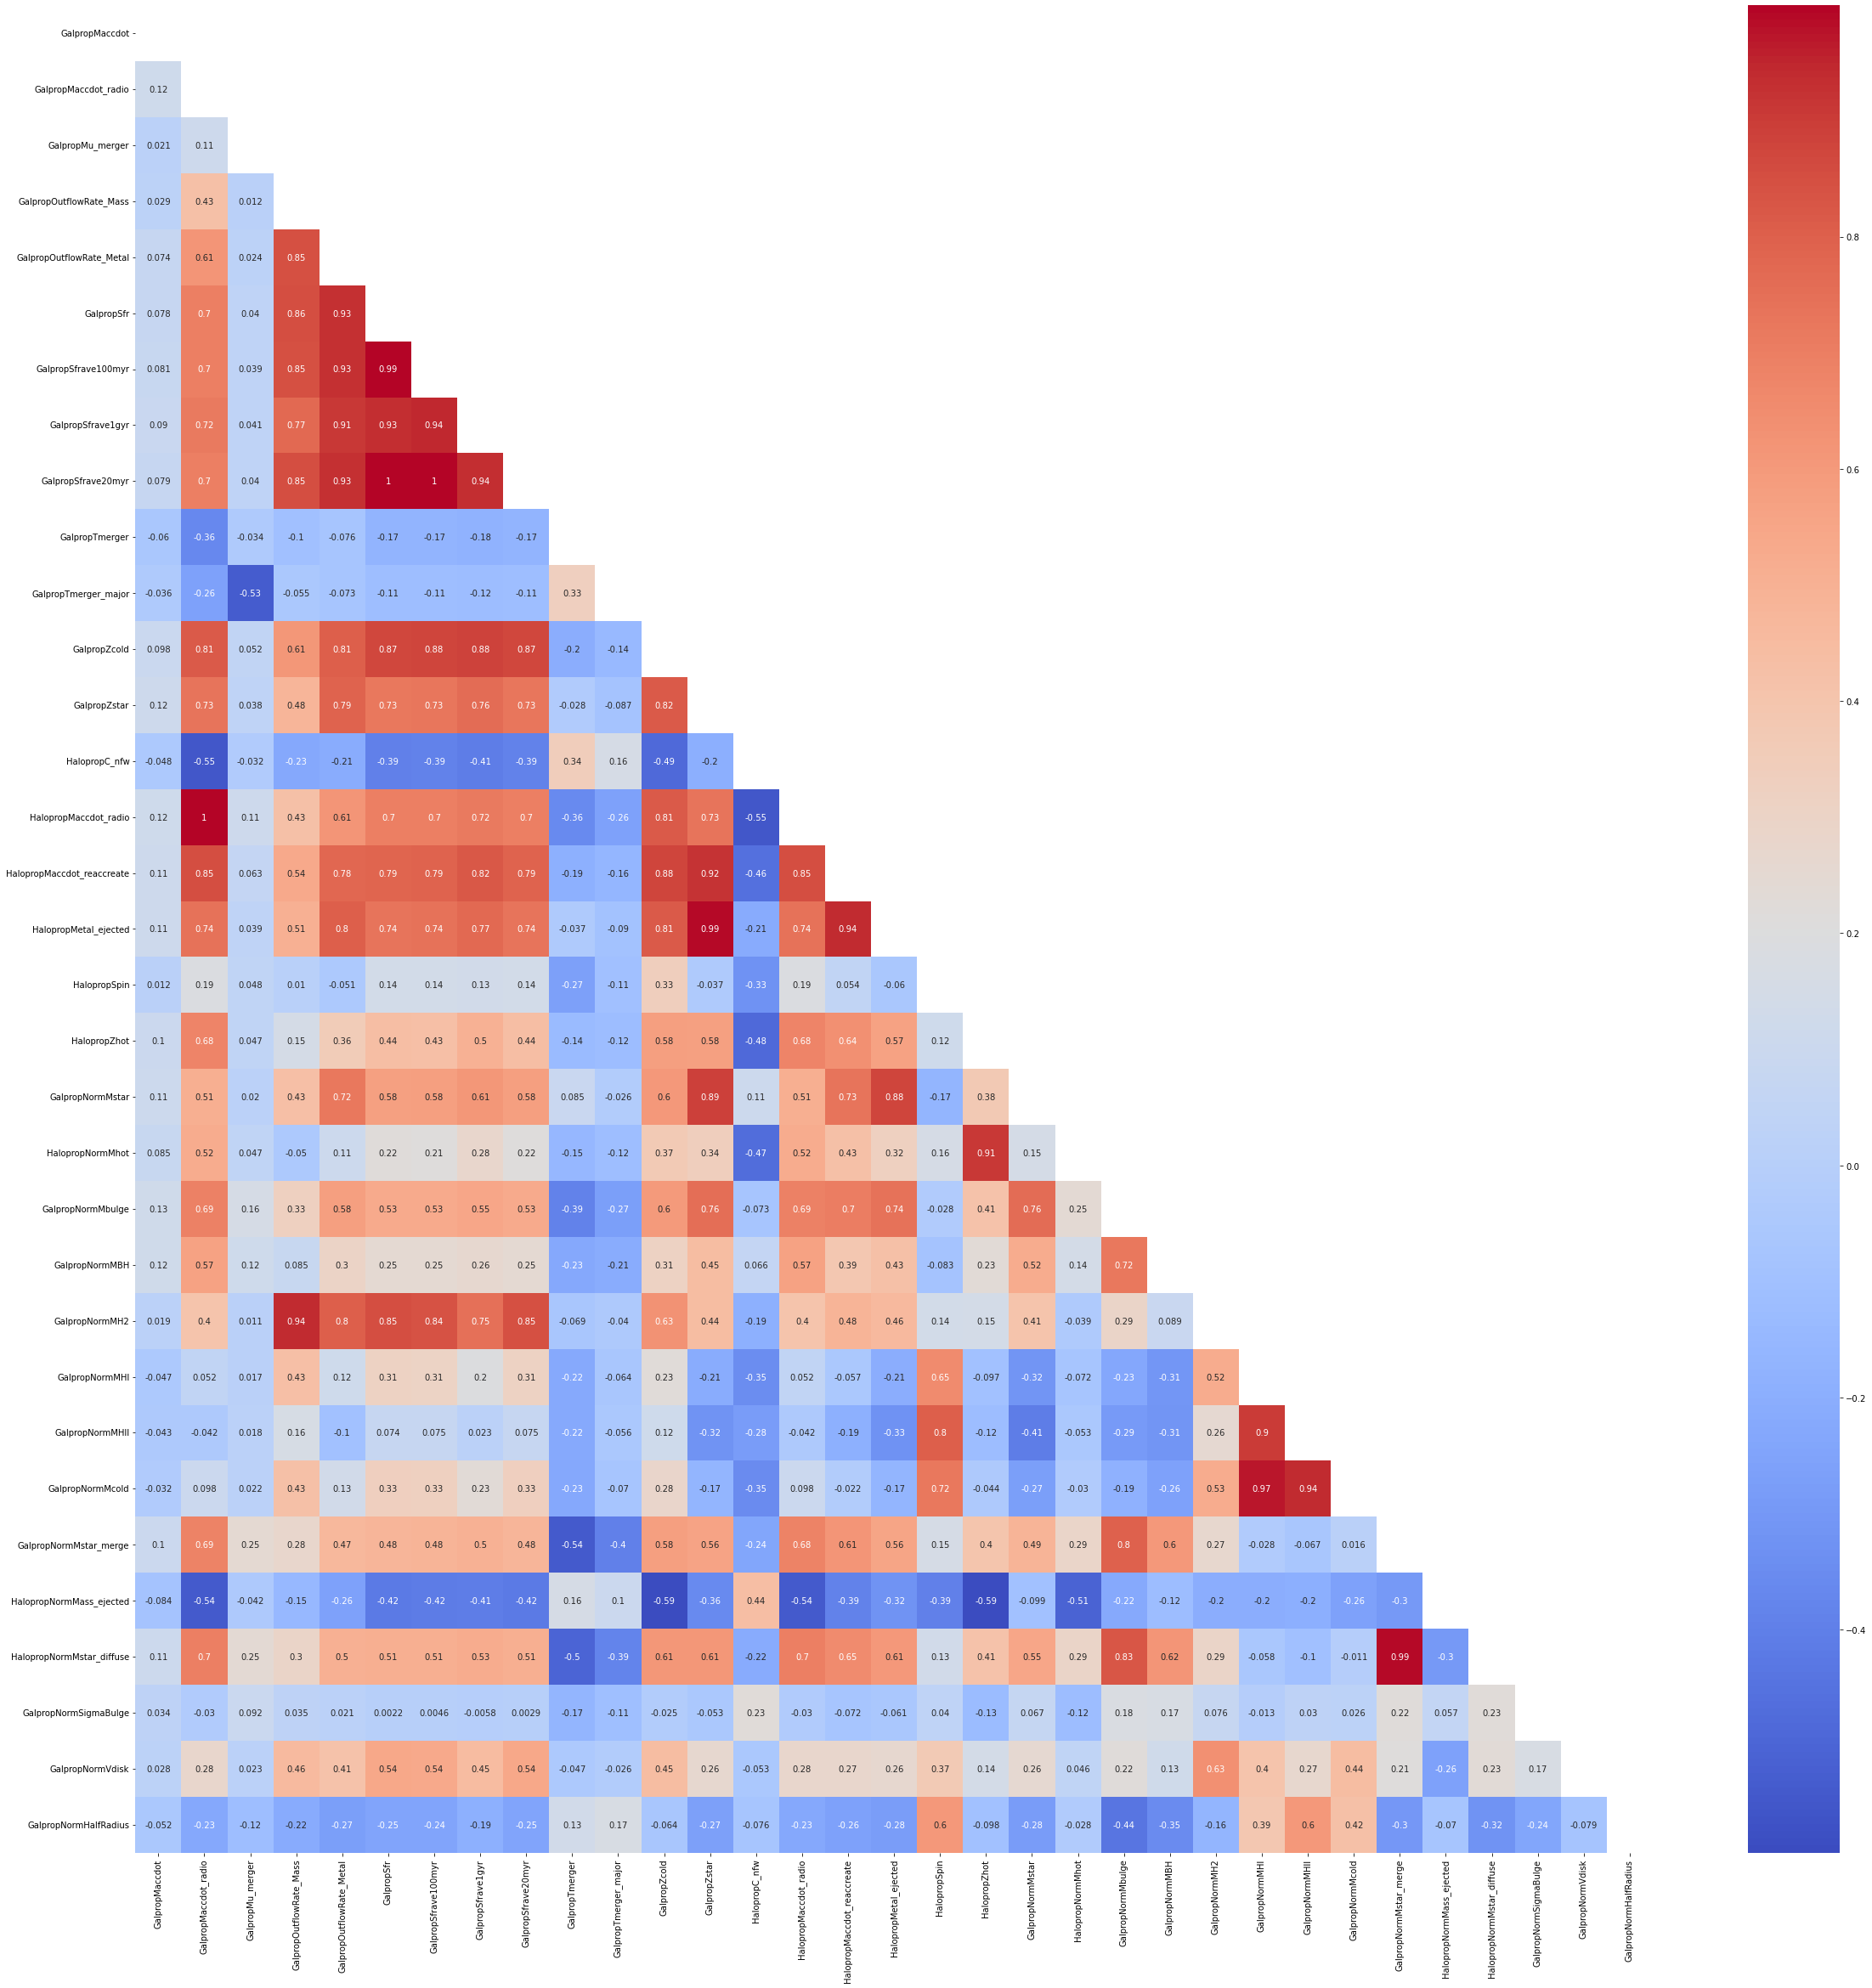

In [34]:
corr_df = df_pairplot.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
# plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
# plt.xlabel("Features", fontsize = 20)
# plt.savefig('TNG-SAM_morefeatures_Spearman_Normalized_correlation_matrix.jpeg', dpi=500)
plt.show()

## <font color='blue'> 1. a. Linear Regression Model - all features

In [36]:
df_normalized.shape

(35390, 33)

In [37]:
X = df_normalized.drop(columns=['GalpropNormHalfRadius'])


y = df_normalized.loc[:,'GalpropNormHalfRadius']

In [8]:
X

NameError: name 'X' is not defined

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
reg = LinearRegression()

In [40]:
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

0.6177533376992264

In [41]:
reg.score(X_test, y_test)

0.5760316956627811

In [42]:
# y_pred_reg=reg.predict(X_test)
y_pred_LR = cross_val_predict(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [43]:
y_pred_LR

array([28.70274842, 23.82113631, 22.82617389, ..., 18.71879236,
       25.72260647, 18.64773104])

In [44]:
scores_reg = cross_val_score(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [45]:
scores_reg

array([0.57542666, 0.41602291, 0.61732121, 0.54169544, 0.6030698 ])

In [46]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_reg.mean(), scores_reg.std() * 2))

Accuracy: 0.55 (+/- 0.14)


In [47]:
scores_reg.mean()

0.5507072041395901

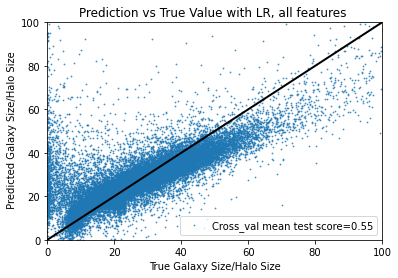

In [48]:
# label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
label='Cross_val mean test score={}'.format(round(scores_reg.mean(),2))

plt.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=3, scalex=False, scaley=False)
plt.title('Prediction vs True Value with LR, all features ')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel(' Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right')

plt.show()

## <font color='blue'> 2.a. Random Forest (RF) - all features

In [57]:
regr_RF = RandomForestRegressor( random_state=0)

In [58]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X, y)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9168 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}


In [59]:
print('Mean test score: {}'.format(rfr_grid.cv_results_['mean_test_score']))
print('Mean train score: {}'.format(rfr_grid.cv_results_['mean_train_score']))

Mean test score: [0.71788532 0.72510127 0.72722292 0.7193469  0.72578439 0.72802173
 0.71953368 0.72581378 0.7280851  0.88069065 0.8862472  0.88877087
 0.88279998 0.88766957 0.89014764 0.88131148 0.88537556 0.8880461
 0.90572092 0.91393403 0.91668386 0.90664868 0.91398628 0.91684328
 0.90480206 0.9106102  0.91320177]
Mean train score: [0.74204359 0.74971414 0.75137755 0.74168956 0.74954997 0.75119633
 0.74161731 0.74909336 0.75074793 0.93984623 0.94541205 0.94695807
 0.93779541 0.94309676 0.94456944 0.93200617 0.93736296 0.93905652
 0.98185723 0.98664003 0.98770878 0.97716057 0.98198495 0.98305924
 0.96594698 0.9709431  0.97217332]


In [60]:
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [61]:
rfr_grid.best_index_

23

In [62]:
rfr_grid.cv_results_['mean_train_score'][23]

0.9830592443288678

In [63]:
best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

In [64]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_RF = cross_val_predict(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [65]:
y_pred_RF

array([19.01502491, 16.92215903, 21.87696591, ..., 18.27882747,
       24.80987318, 21.01489166])

In [66]:
scores_RF = cross_val_score(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [67]:
scores_RF

array([0.92531841, 0.92303026, 0.91611337, 0.90147262, 0.9133866 ])

In [68]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Accuracy: 0.92 (+/- 0.02)


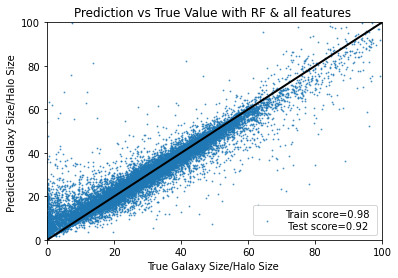

In [69]:
label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

## <font color='red'> 2.b. Random Forest (RF) Feature Importance MDI & Permutation

In [63]:
start_time = time.time()
importances = rfr_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.067 seconds


Elapsed time to compute the importances: 38.358 seconds


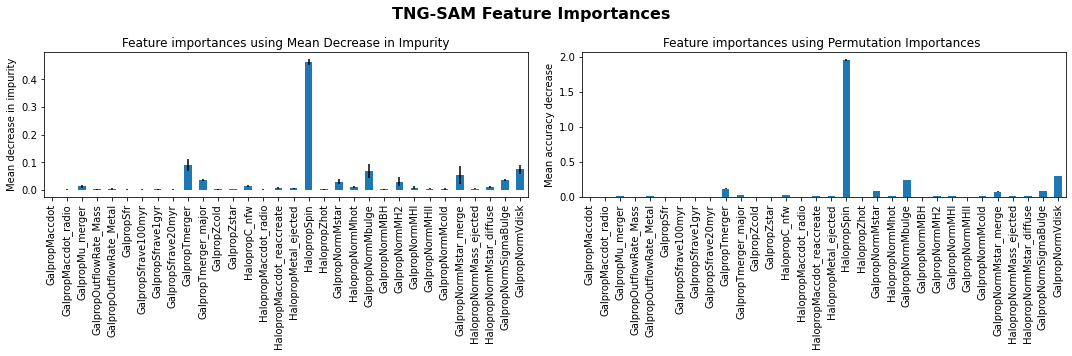

In [64]:

feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

forest_importances.plot.bar(yerr=std, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation


start_time = time.time()
result = permutation_importance(
    rfr_grid.best_estimator_, X, y, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_v2.jpeg", dpi=500)

plt.show()

In [65]:
df_perm_import=pd.DataFrame(forest_importances)

In [66]:
df_perm_import=df_perm_import.sort_values(0, ascending=False)

In [67]:
df_perm_import.head(7)

,0
HalopropSpin,1.953786
GalpropNormVdisk,0.299312
GalpropNormMbulge,0.240740
GalpropTmerger,0.114990
GalpropNormMstar,0.081444
GalpropNormSigmaBulge,0.078683
GalpropNormMstar_merge,0.073973


In [68]:
# df_perm_import.to_csv('Premutation importances RF all features_v2.csv', index=True)

## <font color='blue'> 2.c. Random Forest Model eliminating features - Halo features only

In [68]:
df_log_mass_filtered.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMbulge',
       'GalpropMcold', 'GalpropMstar', 'GalpropMstar_merge',
       'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropRhalo', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropSigmaBulge', 'GalpropTmerger', 'GalpropTmerger_major',
       'GalpropVdisk', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMass_ejected', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropSpin', 'HalopropZhot',
       'GalpropHalfRadius', 'HalopropVvir', 'GalpropNormHalfRadius',
       'GalpropNormRhalo', 'GalpropNormMstar', 'HalopropNormMhot',
       'GalpropNormMbulge', 'GalpropNormMBH', 'GalpropNormMH2',
       'GalpropNormMHI'

In [69]:
X_el = df_normalized.loc[:, ['HalopropC_nfw', 'HalopropSpin']]

y_el = df_normalized.loc[:,'GalpropNormHalfRadius']

In [70]:
X_train_el, X_test_el, y_train_el, y_test_el = train_test_split(X_el, y_el, test_size=0.33, random_state=42)

regr_el = RandomForestRegressor(random_state=0)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid_el = GridSearchCV(estimator = regr_el, param_grid = grid, cv = 3, verbose=1, n_jobs = -1)
# Fit the model
rfr_grid_el.fit(X_train_el, y_train_el)
# print results
print(rfr_grid_el.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 55}


In [71]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_RF_el = cross_val_predict(rfr_grid_el.best_estimator_, X_test_el, y_test_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

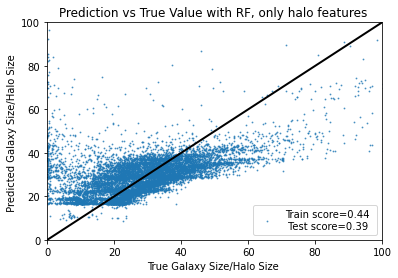

In [72]:
label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
plt.scatter(y_test_el, y_pred_RF_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF, only halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('TNG-SAM_Prediction_vs_True_with_halo_features.jpeg', dpi=500)
plt.show()

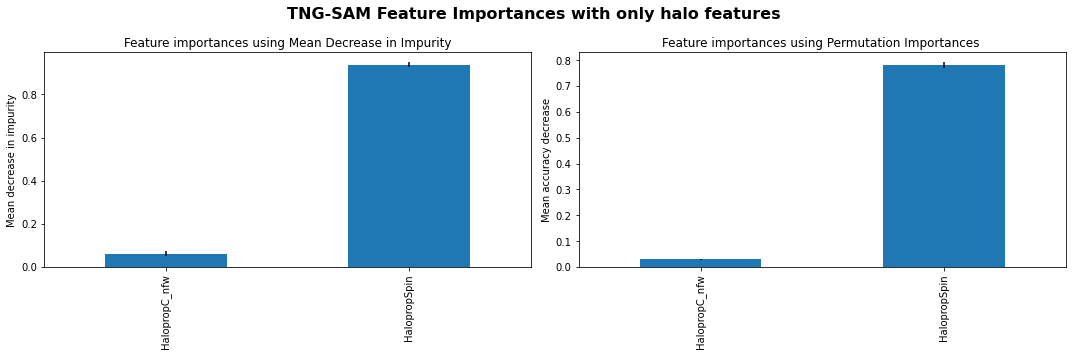

In [73]:
start_time = time.time()
importances_el = rfr_grid_el.best_estimator_.feature_importances_
std_el = np.std([tree.feature_importances_ for tree in rfr_grid_el.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

feature_names_el = X_test_el.columns

forest_importances_el = pd.Series(importances_el, index=feature_names_el)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances with only halo features ', fontsize=16, fontweight='bold')

forest_importances_el.plot.bar(yerr=std_el, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation

start_time = time.time()
result_el = permutation_importance(
    rfr_grid_el.best_estimator_, X_test_el, y_test_el, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_el = pd.Series(result_el.importances_mean, index=feature_names_el)

forest_importances_el.plot.bar(yerr=result_el.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("TNG-SAM_Feature_Importances_Permutation_halo_features.jpeg", dpi=500)

plt.show()

In [74]:
df_perm_import_el=pd.DataFrame(forest_importances_el)

In [75]:
df_perm_import_el.sort_values(0, ascending=False)

,0
HalopropSpin,0.780021
HalopropC_nfw,0.030892


## <font color='blue'> 3.a. Support Vector Machine (SVM) - all features

In [ ]:
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['poly', 'rbf'], \
              'svr__gamma':['scale', 0.01, 0.1], 'svr__C':[1.0, 10, 100, 1000], \
              'svr__degree': [2, 3]}

# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale'], 'svr__C':[100], \
#               'svr__degree': [2]}

model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model.fit(X, y)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the GridSearchCV for SVR: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 3/3] END svr__C=1.0, svr__degree=2, svr__gamma=scale, svr__kernel=poly;, score=(train=0.421, test=-25.112) total time=  46.2s
[CV 1/3] END svr__C=1.0, svr__degree=2, svr__gamma=0.1, svr__kernel=poly;, score=(train=0.533, test=-126.874) total time= 1.2min
[CV 3/3] END svr__C=1.0, svr__degree=2, svr__gamma=0.1, svr__kernel=rbf;, score=(train=0.725, test=0.718) total time=  58.8s
[CV 2/3] END svr__C=1.0, svr__degree=3, svr__gamma=0.01, svr__kernel=poly;, score=(train=0.156, test=0.011) total time=  50.2s
[CV 1/3] END svr__C=1.0, svr__degree=3, svr__gamma=0.1, svr__kernel=rbf;, score=(train=0.715, test=0.734) total time=  58.8s
[CV 3/3] END svr__C=10, svr__degree=2, svr__gamma=scale, svr__kernel=poly;, score=(train=0.543, test=-9.574) total time= 1.0min
[CV 2/3] END svr__C=10, svr__degree=2, svr__gamma=0.01, svr__kernel=poly;, score=(train=0.411, test=0.363) total time=  48.4s
[CV 2/3] END svr__C=10, svr__degree=2, svr__gamm

[CV 2/3] END svr__C=1.0, svr__degree=2, svr__gamma=scale, svr__kernel=poly;, score=(train=0.409, test=0.360) total time=  45.6s
[CV 3/3] END svr__C=1.0, svr__degree=2, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.716, test=0.725) total time=  57.2s
[CV 3/3] END svr__C=1.0, svr__degree=3, svr__gamma=scale, svr__kernel=poly;, score=(train=0.464, test=-58039.417) total time= 2.0min
[CV 2/3] END svr__C=1.0, svr__degree=3, svr__gamma=0.1, svr__kernel=poly;, score=(train=0.774, test=-43.252) total time=13.3min
[CV 2/3] END svr__C=10, svr__degree=3, svr__gamma=0.01, svr__kernel=poly;, score=(train=0.351, test=-0.046) total time= 1.1min
[CV 3/3] END svr__C=10, svr__degree=3, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.811, test=0.814) total time= 1.1min
[CV 2/3] END svr__C=100, svr__degree=2, svr__gamma=scale, svr__kernel=poly;, score=(train=0.624, test=-0.711) total time= 4.5min
[CV 3/3] END svr__C=100, svr__degree=2, svr__gamma=0.01, svr__kernel=poly;, score=(train=0.544, test=-10

#### From the SVR Gridsearch in the line above (125 fits (87%) out of 144), the best parameters are: C=1000, gamma=scale, kernel=rbf (gaussian), train score=0.954, test score=0.926


In [49]:
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }


model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model.fit(X, y)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the GridSearchCV for SVR: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.949, test=0.912) total time= 6.6min
[CV 2/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.922) total time= 6.7min
[CV 3/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.959, test=0.915) total time= 7.7min
Best params, best score: 0.9163 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the GridSearchCV for SVR: 2646.672 seconds


In [50]:
best_SVR=model.best_estimator_

In [51]:
best_SVR_trainscore=model.cv_results_['mean_train_score'][model.best_index_]

In [52]:
scores_SVR = cross_val_score(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [53]:
scores_SVR.mean()

0.9204170233839204

In [54]:
y_pred_SVR = cross_val_predict(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))


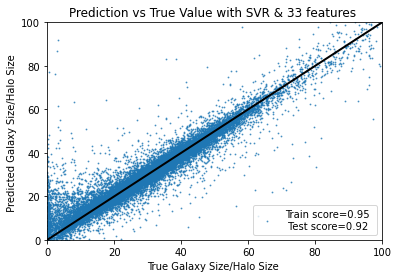

In [56]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y, y_pred_SVR, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with SVR & 33 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True_SVR_33feat.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

## <font color='blue'> 3.b. Support Vector Machine (SVM) - Halo features only

In [94]:
X_el = df_normalized.loc[:, ['HalopropC_nfw', 'HalopropSpin']]

y_el = df_normalized.loc[:,'GalpropNormHalfRadius']

In [95]:
start_time = time.time()

piped_model_el = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model_el.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters_el = {'svr__kernel':['poly', 'rbf'], \
              'svr__gamma':['scale', 0.01, 0.1], 'svr__C':[10, 100, 1000], \
              'svr__degree': [2]}

# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale'], 'svr__C':[100], \
#               'svr__degree': [2]}

model_el = GridSearchCV(piped_model_el, parameters_el, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_el.fit(X_el, y_el)

print('Best params, best score:', "{:.4f}".format(model_el.best_score_), \
      model_el.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the GridSearchCV for SVR-Halo feat: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params, best score: 0.3766 {'svr__C': 10, 'svr__degree': 2, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Elapsed time to compute the GridSearchCV for SVR-Halo feat: 585.860 seconds


In [96]:
scores_lim_el = pd.DataFrame(model_el.cv_results_)

scores_lim_el[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
3,"{'svr__C': 10, 'svr__degree': 2, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}",0.376564,0.016565,0.377713,19.892657
9,"{'svr__C': 100, 'svr__degree': 2, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}",0.373423,0.022585,0.374749,22.665195
15,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}",0.365058,0.025109,0.367292,25.604070
5,"{'svr__C': 10, 'svr__degree': 2, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}",0.364632,0.019336,0.367081,20.950952
17,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}",0.361098,0.021438,0.369937,30.532997
1,"{'svr__C': 10, 'svr__degree': 2, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}",0.360238,0.016184,0.365266,18.712466
11,"{'svr__C': 100, 'svr__degree': 2, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}",0.359530,0.021005,0.367017,24.411660
7,"{'svr__C': 100, 'svr__degree': 2, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}",0.354496,0.016274,0.367061,24.114775
13,"{'svr__C': 1000, 'svr__degree': 2, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}",0.347709,0.013544,0.366714,39.131145
8,"{'svr__C': 100, 'svr__degree': 2, 'svr__gamma': 0.01, 'svr__kernel': 'poly'}",0.181115,0.022047,0.182931,19.748495


In [97]:
best_SVR_el=model_el.best_estimator_

In [98]:
best_SVR_trainscore_el=model_el.cv_results_['mean_train_score'][model_el.best_index_]

In [99]:
scores_SVR_el = cross_val_score(best_SVR_el, X_el, y_el, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [100]:
y_pred_SVR_el = cross_val_predict(best_SVR_el, X_el, y_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

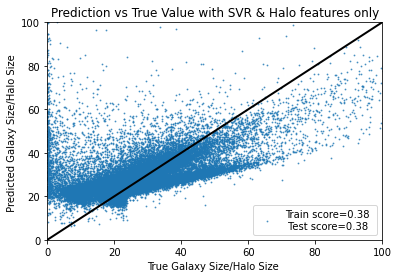

In [101]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_el, 2),round(scores_SVR_el.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_el, y_pred_SVR_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with SVR & Halo features only')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

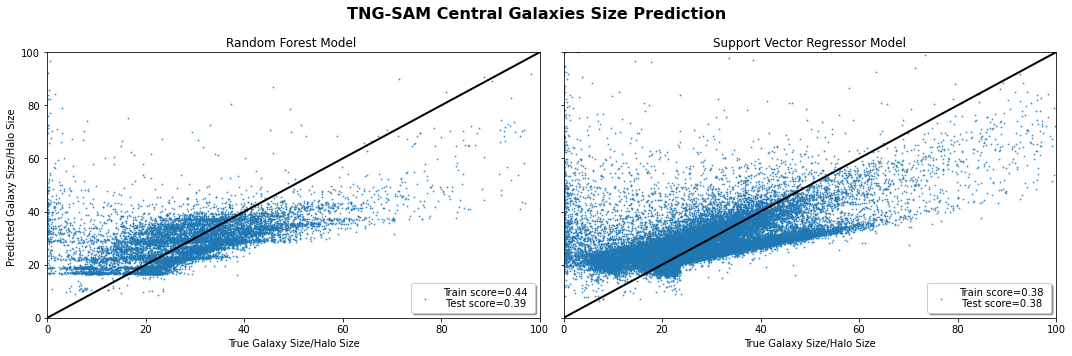

In [113]:
fig,[ax1, ax5 ]=plt.subplots(nrows=1,ncols=2,sharey=True, figsize=(15,5))
# fig.suptitle('TNG-SAM Central Galaxies Size Prediction', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
# print(label)
im1 = ax1.scatter(y_test_el, y_pred_RF_el, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,100, 0.0,100])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Random Forest Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_el, 2),round(scores_SVR_el.mean(), 2) )
im5 = ax5.scatter(y_el, y_pred_SVR_el, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.0,100, 0.0,100])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Support Vector Regressor Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_RF_SVR_size_prediction_halo_only.jpeg", dpi=500)
plt.show()

## <font color='darkred'> The figure containing all the models

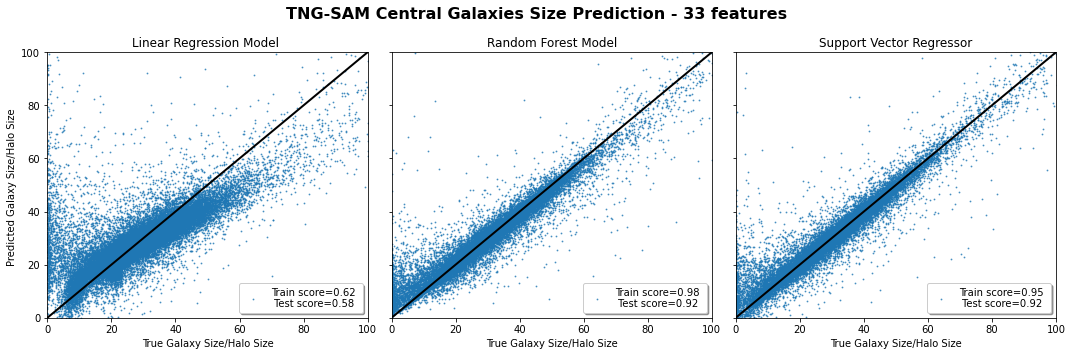

In [73]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction - 33 features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# print(label)
im1 = ax1.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,100, 0.0,100])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.0,100, 0.0,100])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )
im6 = ax6.scatter(y, y_pred_SVR, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,100, 0.0,100])
ax6.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_LR_RF_SVR_size_prediction_33feat.jpeg", dpi=500)
plt.show()

## <font color='orange'> 4. 10-feature analysis

### <font color='orange'> 4.a. Define the dataset for the 10-feature analysis

In [32]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropNormHalfRadius', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk'],
      dtype='object')>

In [33]:
df_normalized_10=df_normalized.loc[:, ['HalopropSpin', 'HalopropC_nfw', 'HalopropNormMhot',
                                      'GalpropSfr',   'GalpropZcold',
                                      'GalpropZstar','GalpropNormMstar', 'GalpropNormMbulge', 'GalpropNormMH2',
                                      'GalpropNormMHI', 'GalpropNormHalfRadius']]

In [34]:
df_normalized_10.head(2)

,HalopropSpin,HalopropC_nfw,HalopropNormMhot,GalpropSfr,GalpropZcold,GalpropZstar,GalpropNormMstar,GalpropNormMbulge,GalpropNormMH2,GalpropNormMHI,GalpropNormHalfRadius
0,0.03378,59.1291,2.110814,0.000402,0.000008,0.004245,0.023338,0.016125,0.000000,6.019998e-21,19.072698
1,0.03407,21.8788,0.000007,0.101277,0.206532,0.485612,0.016625,0.001799,0.001132,3.353354e-03,17.545408


In [35]:
X_10 = df_normalized_10.loc[:, ['HalopropSpin', 'HalopropC_nfw', 'HalopropNormMhot',
                                      'GalpropSfr',   'GalpropZcold',
                                      'GalpropZstar','GalpropNormMstar', 'GalpropNormMbulge', 'GalpropNormMH2',
                                      'GalpropNormMHI']]

y_10 = df_normalized_10.loc[:, 'GalpropNormHalfRadius']

### <font color='orange'> 4.b. SVR of 10-feature analysis

In [37]:
piped_model_10 = make_pipeline(StandardScaler(), SVR())

In [98]:
#optimizing SVR

parameters_10_rbf = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 0.1, 1.0, 10], 'svr__C':[10, 100, 1000, 10000], \
              }

model_10_rbf = RandomizedSearchCV(piped_model_10, parameters_10_rbf, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True)

model_10_rbf.fit(X_10, y_10)

print('Best params, best score:', "{:.4f}".format(model_10_rbf.best_score_), \
      model_10_rbf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .......svr__C=1000, svr__gamma=10, svr__kernel=rbf; total time=155.5min
[CV] END .......svr__C=1000, svr__gamma=10, svr__kernel=rbf; total time=158.6min
[CV] END ......svr__C=10000, svr__gamma=0.1, svr__kernel=rbf; total time=33.2min
[CV] END ......svr__C=100, svr__gamma=scale, svr__kernel=rbf; total time= 1.3min
[CV] END ......svr__C=100, svr__gamma=scale, svr__kernel=rbf; total time= 1.3min
[CV] END ......svr__C=100, svr__gamma=scale, svr__kernel=rbf; total time= 1.4min
[CV] END .......svr__C=1000, svr__gamma=0.1, svr__kernel=rbf; total time= 4.1min
[CV] END .......svr__C=1000, svr__gamma=0.1, svr__kernel=rbf; total time= 4.3min
[CV] END .........svr__C=100, svr__gamma=10, svr__kernel=rbf; total time=15.7min
[CV] END .....svr__C=1000, svr__gamma=scale, svr__kernel=rbf; total time= 4.1min
[CV] END .....svr__C=1000, svr__gamma=scale, svr__kernel=rbf; total time= 4.1min
[CV] END .....svr__C=1000, svr__gamma=scale, svr

In [38]:
parameters_10_poly = {'svr__kernel':['poly'], \
              'svr__gamma':['scale', 0.01, 0.1, 1.0], 'svr__C':[ 100, 1000, 10000], \
              'svr__degree': [2]}

model_10_poly = RandomizedSearchCV(piped_model_10, parameters_10_poly, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model_10_poly.fit(X_10, y_10)

print('Best params, best score:', "{:.4f}".format(model_10_poly.best_score_), \
      model_10_poly.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [49]:
scores_lim_10 = pd.DataFrame(model_10.cv_results_)

scores_lim_10[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
4,"{'svr__C': 1000, 'svr__gamma': 'scale', 'svr__...",0.735990,0.008320,0.792737,154.598358
6,"{'svr__C': 1000, 'svr__gamma': 0.1, 'svr__kern...",0.735988,0.008320,0.792736,141.485211
3,"{'svr__C': 100, 'svr__gamma': 1.0, 'svr__kerne...",0.691889,0.013118,0.822238,130.853922
0,"{'svr__C': 100, 'svr__gamma': 'scale', 'svr__k...",0.689887,0.013662,0.715780,33.951666
2,"{'svr__C': 100, 'svr__gamma': 0.1, 'svr__kerne...",0.689887,0.013662,0.715780,34.966759
7,"{'svr__C': 1000, 'svr__gamma': 1.0, 'svr__kern...",0.684889,0.011905,0.905587,983.501806
5,"{'svr__C': 1000, 'svr__gamma': 0.01, 'svr__ker...",0.643423,0.007780,0.653039,43.269119
1,"{'svr__C': 100, 'svr__gamma': 0.01, 'svr__kern...",0.590498,0.006189,0.595659,24.653649


In [50]:
best_SVR_10=model_10.best_estimator_

In [51]:
best_SVR_trainscore_10=model_10.cv_results_['mean_train_score'][model_10.best_index_]

In [52]:
scores_SVR_10 = cross_val_score(best_SVR_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [53]:
scores_SVR_10

array([0.7521506 , 0.73381236, 0.76474652, 0.84145923, 0.69572441])

In [54]:
scores_SVR_10.std()

0.04797411262183349

In [55]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_SVR_10.mean(), scores_SVR_10.std() * 2))

Accuracy: 0.76 (+/- 0.10)


In [56]:
y_pred_SVR_10 = cross_val_predict(best_SVR_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

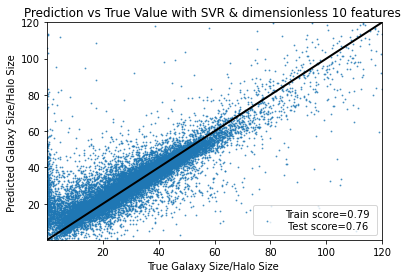

In [64]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_10, 2),round(scores_SVR_10.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_10, y_pred_SVR_10, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,120, 0.1,120])
plt.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with SVR & dimensionless 10 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True_SVR_updated10feat.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

### <font color='orange'> 4.c. RF of 10-feature analysis

In [65]:
regr_RF = RandomForestRegressor(random_state=0)

In [67]:
# number of trees in random forest
n_estimators_10 = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid_10 = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators_10}
# Random search of parameters
# rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = 3, verbose=1, n_jobs = -1)
rfr_grid_10 = GridSearchCV(estimator = regr_RF, param_grid = grid_10, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_10.fit(X_10, y_10)

print('Best params, best score:', "{:.4f}".format(rfr_grid_10.best_score_), \
    rfr_grid_10.best_params_)



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9204 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}


In [68]:
print('Mean test score: {}'.format(rfr_grid_10.cv_results_['mean_test_score']))
print('Mean train score: {}'.format(rfr_grid_10.cv_results_['mean_train_score']))

Mean test score: [0.6746526  0.67937558 0.67841823 0.67471924 0.67980291 0.67868787
 0.67487367 0.6800269  0.67891766 0.88514279 0.89435288 0.89480993
 0.88526077 0.89437796 0.89512897 0.88610566 0.89395653 0.89443588
 0.90821643 0.91906398 0.9201186  0.91038673 0.91954195 0.92042388
 0.90959496 0.91705988 0.91762754]
Mean train score: [0.69718138 0.70191053 0.70127453 0.69657027 0.70148302 0.70077701
 0.69616026 0.70075728 0.70004087 0.93611542 0.94186206 0.94214894
 0.93376927 0.93936097 0.93959144 0.9288849  0.93402184 0.93422439
 0.98211975 0.98803058 0.98854901 0.97597654 0.98164868 0.98212056
 0.96336194 0.96854175 0.9690017 ]


In [69]:
best_RF_10=rfr_grid_10.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [70]:
rfr_grid_10.best_index_

23

In [71]:
rfr_grid_10.cv_results_['mean_train_score'][23]

0.9821205633443617

In [73]:
best_RF_trainscore_10=rfr_grid_10.cv_results_['mean_train_score'][rfr_grid_10.best_index_]

In [74]:
best_RF_trainscore_10

0.9821205633443617

In [75]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_RF_10 = cross_val_predict(best_RF_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [76]:
y_pred_RF_10

array([13.46591965, 17.05874313, 21.22617797, ..., 18.08398195,
       25.13512687, 21.09762198])

In [77]:
scores_RF_10 = cross_val_score(best_RF_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [78]:
scores_RF_10

array([0.92897373, 0.92578988, 0.92566751, 0.91487583, 0.90912701])

In [79]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_10.mean(), scores_RF_10.std() * 2))

Accuracy: 0.92 (+/- 0.02)


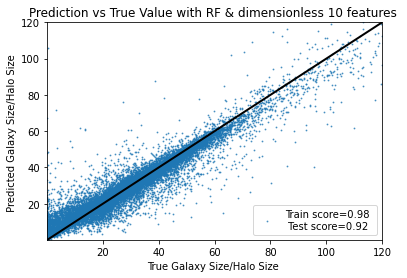

In [81]:
label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_10, 2),round(scores_RF_10.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_10, y_pred_RF_10, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,120, 0.1,120])
plt.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & dimensionless 10 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True_updated10feat.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

### <font color='orange'> 4.d. LR of 10-feature analysis

In [82]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.33, random_state=42)

In [83]:
reg = LinearRegression()
reg.fit(X_train_10, y_train_10)

reg.score(X_train_10, y_train_10)

0.4728362747635678

In [84]:
reg.score(X_test_10, y_test_10)

0.4505803332451268

In [85]:
y_pred_LR_10 = cross_val_predict(reg, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [86]:
y_pred_LR_10

array([21.70219472, 26.52090823, 18.2391316 , ..., 25.07268195,
       31.20389839, 17.74047024])

In [87]:
scores_reg_10 = cross_val_score(reg, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [88]:
scores_reg_10

array([0.46617654, 0.44196455, 0.47140431, 0.31860407, 0.47556691])

In [89]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_reg_10.mean(), scores_reg_10.std() * 2))

Accuracy: 0.43 (+/- 0.12)


In [90]:
scores_reg_10.mean()

0.4347432764494202

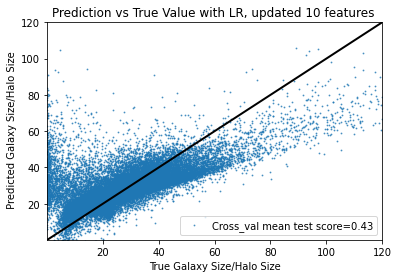

In [92]:
# label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
label='Cross_val mean test score={}'.format(round(scores_reg_10.mean(),2))

plt.scatter(y_10, y_pred_LR_10, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,120, 0.1,120])
plt.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=3, scalex=False, scaley=False)
plt.title('Prediction vs True Value with LR, updated 10 features ')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel(' Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right')

plt.show()

## <font color='darkred'> The figure containing all the models - 10 features

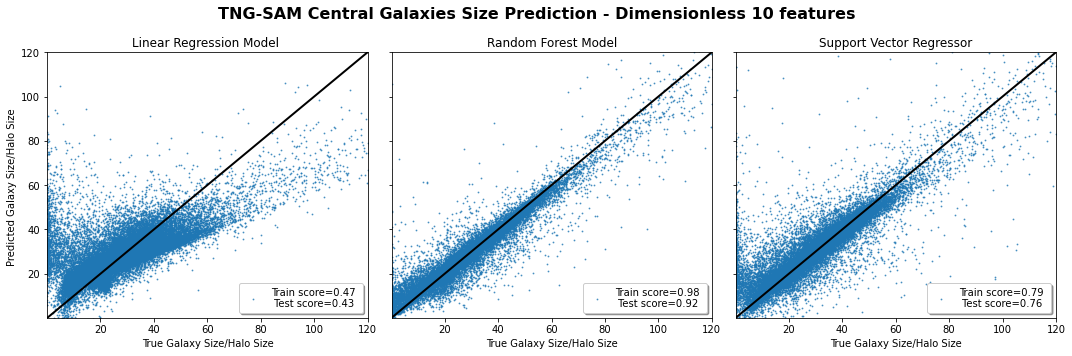

In [94]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction - Dimensionless 10 features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train_10, y_train_10), 2),round(scores_reg_10.mean(), 2) )
# print(label)
im1 = ax1.scatter(y_10, y_pred_LR_10, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,120, 0.1,120])
ax1.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_10, 2),round(scores_RF_10.mean(), 2) )
im5 = ax5.scatter(y_10, y_pred_RF_10, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,120, 0.1,120])
ax5.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_10, 2),round(scores_SVR_10.mean(), 2) )
im6 = ax6.scatter(y_10, y_pred_SVR_10, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,120, 0.1,120])
ax6.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_LR_RF_SVR_size_prediction_dimensionless_10feat.jpeg", dpi=500)
plt.show()